In [215]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("white")

In [216]:
years = [2012, 2013, 2014, 2015, 2016]

## Preparing Weather Data

In [217]:
weather_data = pd.DataFrame()

for year in years:
    year_data = pd.read_csv('../data/{}.csv'.format(year), index_col=0)
    weather_data = pd.concat([weather_data, year_data])
    
weather_data.shape

(1824, 22)

In [218]:
weather_data.columns

Index(['stn', 'wban', 'yearmoda', 'temp', 'count_temp', 'dewp', 'count_dewp',
       'slp', 'count_slp', 'stp', 'count_stp', 'visib', 'count_visib', 'wdsp',
       'count_wdsp', 'mxspd', 'gust', 'max', 'min', 'prcp', 'sndp', 'frshtt'],
      dtype='object')

In [219]:
weather_data.head()

,stn,wban,yearmoda,temp,count_temp,dewp,count_dewp,slp,count_slp,stp,...,count_visib,wdsp,count_wdsp,mxspd,gust,max,min,prcp,sndp,frshtt
0,337610,99999,20120101,28.8,8,25.7,8,1019.2,8,996.1,...,8,4.4,8,5.8,999.9,33.8,24.8,0.00I,999.9,100000
1,337610,99999,20120102,30.2,8,26.0,8,1021.2,8,998.2,...,8,5.3,8,7.8,999.9,35.6,24.4,0.00I,999.9,0
2,337610,99999,20120103,34.3,8,31.1,8,1020.3,8,997.5,...,8,5.1,8,7.8,999.9,37.9,29.7,0.00I,999.9,0
3,337610,99999,20120104,35.9,8,35.8,8,1017.7,8,995.0,...,8,6.1,8,7.8,999.9,39.2,31.8,0.00I,999.9,100000
4,337610,99999,20120105,36.5,8,35.4,8,1005.9,8,983.5,...,8,6.1,8,11.7,999.9,41.9,32.2,99.99,999.9,110000


In [220]:
weather_data.drop(weather_data.columns[[0, 1,4,6,8,10,12,14,16]], axis=1, inplace=True)
weather_data['year'] = weather_data['yearmoda'] // 10000
weather_data['month'] = weather_data['yearmoda'] // 100 % 100
weather_data['day'] = weather_data['yearmoda'] % 100
weather_data['sndp'].replace(999.9,0, inplace = True)
weather_data['yearmoda1'] = weather_data['yearmoda'].astype(str).apply(lambda x: x[:9])
weather_data.index = pd.to_datetime(weather_data['yearmoda1'], format='%Y%m%d').values
weather_data.drop(weather_data.columns[[0,16]], axis=1, inplace=True)
for x in weather_data[weather_data['wdsp'] == 999.9].index:
    weather_data.loc[x,'wdsp'] = np.NaN
weather_data['wdsp'] = weather_data['wdsp'].interpolate(method='time')
for x in weather_data[weather_data['mxspd'] == 999.9].index:
    weather_data.loc[x,'mxspd'] = np.NaN
weather_data['mxspd'] = weather_data['mxspd'].interpolate(method='time')
for x in weather_data[weather_data['prcp'] == '99.99'].index:
    weather_data.loc[x,'prcp'] = np.NaN
for x in weather_data.index:
    if (str(weather_data.loc[x,'prcp'])[-1] == 'I') or (str(weather_data.loc[x,'prcp'])[-1] == 'H'):
        weather_data.loc[x,'prcp'] = np.NaN
for x in weather_data[weather_data['prcp'].notnull()].index:
    weather_data.loc[x,'prcp'] = weather_data.loc[x,'prcp'][:-1]
for x in weather_data.index:
    if (str(weather_data.loc[x,'max'])[-1] == '*'):
        weather_data.loc[x,'max'] = weather_data.loc[x,'max'][:-1]
    if (str(weather_data.loc[x,'min'])[-1] == '*'):
        weather_data.loc[x,'min'] = weather_data.loc[x,'min'][:-1]
weather_data['max']=weather_data['max'].astype(np.float64)
weather_data['min']=weather_data['min'].astype(np.float64)
weather_data['prcp']=weather_data['prcp'].astype(np.float64)
weather_data['prcp'] = weather_data['prcp'].interpolate(method='time')

In [221]:
weather_data['fog'] = weather_data['frshtt'] // 100000
weather_data['rain'] = weather_data['frshtt'] // 10000 % 10
weather_data['snow'] = weather_data['frshtt'] // 1000 % 10
weather_data['hail'] = weather_data['frshtt'] // 100 % 10
weather_data['thunder'] = weather_data['frshtt'] // 10 % 10
weather_data['tornado'] = weather_data['frshtt'] % 10
weather_data.drop(['frshtt'],axis = 1, inplace = True)

In [222]:
weather_data.head()

,temp,dewp,slp,stp,visib,wdsp,mxspd,max,min,prcp,sndp,year,month,day,fog,rain,snow,hail,thunder,tornado
2012-01-01,28.8,25.7,1019.2,996.1,6.4,4.4,5.8,33.8,24.8,NaN,0.0,2012,1,1,1,0,0,0,0,0
2012-01-02,30.2,26.0,1021.2,998.2,8.4,5.3,7.8,35.6,24.4,NaN,0.0,2012,1,2,0,0,0,0,0,0
2012-01-03,34.3,31.1,1020.3,997.5,5.8,5.1,7.8,37.9,29.7,NaN,0.0,2012,1,3,0,0,0,0,0,0
2012-01-04,35.9,35.8,1017.7,995.0,0.4,6.1,7.8,39.2,31.8,NaN,0.0,2012,1,4,1,0,0,0,0,0
2012-01-05,36.5,35.4,1005.9,983.5,3.1,6.1,11.7,41.9,32.2,NaN,0.0,2012,1,5,1,1,0,0,0,0


In [223]:
columns = [col for col in weather_data.columns if col not in ['month', 'day']]
weather_data = weather_data[columns]

In [224]:
weather_data['week'] = weather_data.index.week

In [225]:
weather_data_week = weather_data.groupby(['year', 'week']).mean()

In [226]:
weather_data_week.head()

temp       dewp          slp          stp      visib  \
year week                                                              
2012 1     33.975000  31.125000  1013.012500   990.325000   5.025000   
     2     30.142857  26.471429  1014.542857   991.642857   8.185714   
     3     24.685714  22.685714  1016.514286   993.285714   4.442857   
     4     13.242857   8.028571  1026.742857  1002.700000   8.300000   
     5      2.885714  -2.000000  1035.971429  1011.200000  11.328571   

               wdsp      mxspd        max        min      prcp      sndp  \
year week                                                                  
2012 1     6.275000   9.250000  37.850000  29.687500  0.174167  0.487500   
     2     6.242857   8.042857  34.471429  25.871429  0.053571  1.857143   
     3     4.442857   6.942857  28.500000  20.142857  0.184286  2.485714   
     4     8.500000  11.371429  17.428571   9.600000  0.067500  8.814286   
     5     8.085714  11.100000   8.028571  -2.800000  0.034643  7.785714   

                fog      rain      snow  hail  thunder  tornado  
year week                                                        
2012 1     0.250000  0.375000  0.250000   0.0      0.0      0.0  
     2     0.000000  0.142857  0.285714   0.0      0.0      0.0  
     3     0.142857  0.142857  0.857143   0.0      0.0      0.0  
     4     0.428571  0.000000  0.000000   0.0      0.0      0.0  
     5     0.000000  0.000000  0.285714   0.0      0.0      0.0

In [227]:
weather_data_week.reset_index(inplace=True)
weather_data_week.head()

,year,week,temp,dewp,slp,stp,visib,wdsp,mxspd,max,min,prcp,sndp,fog,rain,snow,hail,thunder,tornado
0,2012,1,33.975000,31.125000,1013.012500,990.325000,5.025000,6.275000,9.250000,37.850000,29.687500,0.174167,0.487500,0.250000,0.375000,0.250000,0.0,0.0,0.0
1,2012,2,30.142857,26.471429,1014.542857,991.642857,8.185714,6.242857,8.042857,34.471429,25.871429,0.053571,1.857143,0.000000,0.142857,0.285714,0.0,0.0,0.0
2,2012,3,24.685714,22.685714,1016.514286,993.285714,4.442857,4.442857,6.942857,28.500000,20.142857,0.184286,2.485714,0.142857,0.142857,0.857143,0.0,0.0,0.0
3,2012,4,13.242857,8.028571,1026.742857,1002.700000,8.300000,8.500000,11.371429,17.428571,9.600000,0.067500,8.814286,0.428571,0.000000,0.000000,0.0,0.0,0.0
4,2012,5,2.885714,-2.000000,1035.971429,1011.200000,11.328571,8.085714,11.100000,8.028571,-2.800000,0.034643,7.785714,0.000000,0.000000,0.285714,0.0,0.0,0.0


## Preparing Yield Data

In [228]:
def get_year_culture_week_ndvi():
    data = pd.DataFrame(columns = ['year', 'culture', 'field', 'week', 'ndvi', 'yields'])
    
    for year in years:
        df = pd.read_excel('../Сводная вегетация.xlsx', sheetname=str(year), header=1)

        ndvi_columns = [col for col in df.columns if 'неделя' in col]
        culture_column = 'Культура ' + str(year)
        field_column = 'Поле'
        yields_column = 'Урожайность, т./га.'
        interesting_columns = [culture_column, field_column] + ndvi_columns + [yields_column]
        
        df = df[interesting_columns]
        data_array = []
        
        for i in range(df.shape[0]):
            for j in range(2, df.shape[1] - 1):
                culture = df.iloc[i][culture_column]
                field = df.iloc[i][field_column]
                week = df.columns[j].replace('неделя ', '')
                ndvi = df.iloc[i, j]
                yields = df.iloc[i][yields_column]
                
                row = [year, culture, field, week, ndvi, yields]
                data_array.append(row)
                
        data_array = np.array(data_array)
        data_frame = pd.DataFrame(data_array, columns=data.columns)
        data = pd.concat([data, data_frame[data_frame['ndvi'] != 'nan']])
        
    return data

In [229]:
yield_data = get_year_culture_week_ndvi()
yield_data.head()

,year,culture,field,week,ndvi,yields
5,2012,Подсолнечник,10,48,0.382,2.7
6,2012,Подсолнечник,10,47,0.38,2.7
8,2012,Подсолнечник,10,45,0.353,2.7
10,2012,Подсолнечник,10,43,0.341,2.7
11,2012,Подсолнечник,10,42,0.354,2.7


In [230]:
yield_data.dtypes

year       object
culture    object
field      object
week       object
ndvi       object
yields     object
dtype: object

In [231]:
yield_data['year'] = yield_data['year'].astype(int)
yield_data['week'] = yield_data['week'].astype(int)
yield_data['ndvi'] = yield_data['ndvi'].astype(float)
yield_data['yields'] = yield_data['yields'].astype(float)

In [232]:
le = LabelEncoder()
yield_data['field'] = le.fit_transform(yield_data['field'])

In [233]:
yield_data.dropna(inplace=True)

In [234]:
yield_data_culture = yield_data[yield_data['culture'] == 'Подсолнечник'][['year', 'field', 'week', 'ndvi', 'yields']]

In [235]:
yield_data_week = yield_data_culture.groupby(['field', 'year', 'week']).mean()

In [236]:
yield_data_week.head()

ndvi  yields
field year week               
1     2012 11    0.216    0.77
           12    0.229    0.77
           14    0.232    0.77
           15    0.278    0.77
           16    0.322    0.77

In [237]:
yield_data_week.reset_index(inplace=True)
yield_data_week.head()

,field,year,week,ndvi,yields
0,1,2012,11,0.216,0.77
1,1,2012,12,0.229,0.77
2,1,2012,14,0.232,0.77
3,1,2012,15,0.278,0.77
4,1,2012,16,0.322,0.77


## Combining the datasets

In [238]:
data_week = pd.merge(weather_data_week, yield_data_week, on=['year', 'week'])

In [239]:
data_week.head()

,year,week,temp,dewp,slp,stp,visib,wdsp,mxspd,max,...,sndp,fog,rain,snow,hail,thunder,tornado,field,ndvi,yields
0,2012,1,33.975000,31.125000,1013.012500,990.325,5.025000,6.275000,9.250000,37.850000,...,0.487500,0.250000,0.375,0.25,0.0,0.0,0.0,133,0.280,0.13
1,2012,1,33.975000,31.125000,1013.012500,990.325,5.025000,6.275000,9.250000,37.850000,...,0.487500,0.250000,0.375,0.25,0.0,0.0,0.0,134,0.240,0.97
2,2012,11,38.257143,29.414286,1019.242857,996.600,9.971429,5.457143,7.771429,45.957143,...,2.971429,0.142857,0.000,0.00,0.0,0.0,0.0,1,0.216,0.77
3,2012,11,38.257143,29.414286,1019.242857,996.600,9.971429,5.457143,7.771429,45.957143,...,2.971429,0.142857,0.000,0.00,0.0,0.0,0.0,2,0.211,2.70
4,2012,11,38.257143,29.414286,1019.242857,996.600,9.971429,5.457143,7.771429,45.957143,...,2.971429,0.142857,0.000,0.00,0.0,0.0,0.0,7,0.266,0.75


In [240]:
data_week.dropna(inplace=True)

In [241]:
data_week.reset_index(inplace=True)

In [242]:
data_week.iloc[:,1:].head()

,year,week,temp,dewp,slp,stp,visib,wdsp,mxspd,max,...,sndp,fog,rain,snow,hail,thunder,tornado,field,ndvi,yields
0,2012,1,33.975000,31.125000,1013.012500,990.325,5.025000,6.275000,9.250000,37.850000,...,0.487500,0.250000,0.375,0.25,0.0,0.0,0.0,133,0.280,0.13
1,2012,1,33.975000,31.125000,1013.012500,990.325,5.025000,6.275000,9.250000,37.850000,...,0.487500,0.250000,0.375,0.25,0.0,0.0,0.0,134,0.240,0.97
2,2012,11,38.257143,29.414286,1019.242857,996.600,9.971429,5.457143,7.771429,45.957143,...,2.971429,0.142857,0.000,0.00,0.0,0.0,0.0,1,0.216,0.77
3,2012,11,38.257143,29.414286,1019.242857,996.600,9.971429,5.457143,7.771429,45.957143,...,2.971429,0.142857,0.000,0.00,0.0,0.0,0.0,2,0.211,2.70
4,2012,11,38.257143,29.414286,1019.242857,996.600,9.971429,5.457143,7.771429,45.957143,...,2.971429,0.142857,0.000,0.00,0.0,0.0,0.0,7,0.266,0.75


In [243]:
data_week.iloc[:,1:].to_csv('~/Desktop/ndvi-weather.csv', index=False)

In [244]:
data_week.shape

(5661, 23)

## Train / test split

In [245]:
train_data = data_week[data_week['year'] != 2015]
test_data = data_week[data_week['year'] == 2015]

In [246]:
x_cols = list(data_week.columns.copy())
x_cols.remove('yields')

X_train = train_data[x_cols]
X_test = test_data[x_cols]

y_train = train_data['yields']
y_test = test_data['yields']

In [247]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (3689, 22)
X_test: (1972, 22)
y_train: (3689,)
y_test: (1972,)


## Scaling input values

In [248]:
columns = X_train.columns
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

In [249]:
X_train.head()

,index,year,week,temp,dewp,slp,stp,visib,wdsp,mxspd,...,prcp,sndp,fog,rain,snow,hail,thunder,tornado,field,ndvi
0,0.000000,0.0,0.000000,0.216946,0.304573,0.350117,0.328012,0.238569,0.521263,0.326441,...,0.196768,0.085741,0.333333,0.375,0.4375,0.0,0.0,0.0,0.862745,0.188341
1,0.000271,0.0,0.000000,0.216946,0.304573,0.350117,0.328012,0.238569,0.521263,0.326441,...,0.196768,0.085741,0.333333,0.375,0.4375,0.0,0.0,0.0,0.869281,0.128550
2,0.000542,0.0,0.196078,0.289665,0.266412,0.577384,0.571904,0.749263,0.373711,0.196742,...,0.063267,0.522613,0.190476,0.000,0.0000,0.0,0.0,0.0,0.000000,0.092676
3,0.000813,0.0,0.196078,0.289665,0.266412,0.577384,0.571904,0.749263,0.373711,0.196742,...,0.063267,0.522613,0.190476,0.000,0.0000,0.0,0.0,0.0,0.006536,0.085202
4,0.001085,0.0,0.196078,0.289665,0.266412,0.577384,0.571904,0.749263,0.373711,0.196742,...,0.063267,0.522613,0.190476,0.000,0.0000,0.0,0.0,0.0,0.039216,0.167414


In [250]:
X_test.head()

,index,year,week,temp,dewp,slp,stp,visib,wdsp,mxspd,...,prcp,sndp,fog,rain,snow,hail,thunder,tornado,field,ndvi
0,0.000000,0.0,0.0,0.16746,0.342932,0.540741,0.53314,0.0,0.388451,0.233509,...,0.031746,0.166667,1.0,0.833333,0.333333,0.0,0.0,0.0,0.000000,0.170897
1,0.000507,0.0,0.0,0.16746,0.342932,0.540741,0.53314,0.0,0.388451,0.233509,...,0.031746,0.166667,1.0,0.833333,0.333333,0.0,0.0,0.0,0.007634,0.059222
2,0.001015,0.0,0.0,0.16746,0.342932,0.540741,0.53314,0.0,0.388451,0.233509,...,0.031746,0.166667,1.0,0.833333,0.333333,0.0,0.0,0.0,0.022901,0.099831
3,0.001522,0.0,0.0,0.16746,0.342932,0.540741,0.53314,0.0,0.388451,0.233509,...,0.031746,0.166667,1.0,0.833333,0.333333,0.0,0.0,0.0,0.175573,0.093063
4,0.002029,0.0,0.0,0.16746,0.342932,0.540741,0.53314,0.0,0.388451,0.233509,...,0.031746,0.166667,1.0,0.833333,0.333333,0.0,0.0,0.0,0.419847,0.153976


## Model training

In [251]:
def r2_of(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

In [252]:
r2_of(RandomForestRegressor())

-1.157435230533526

In [253]:
r2_of(LinearRegression())

-3.2097262799983293

In [254]:
r2_of(SVR())

-0.036815268701753112

## Visualizations

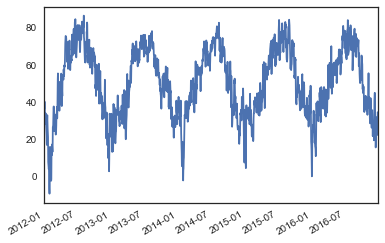

In [255]:
weather_data.temp.plot()

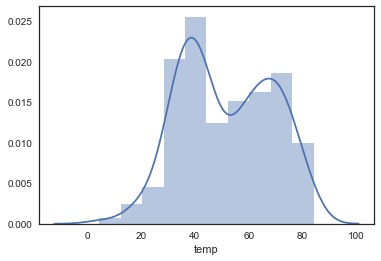

In [256]:
sns.distplot(weather_data[weather_data.year == 2015].temp)

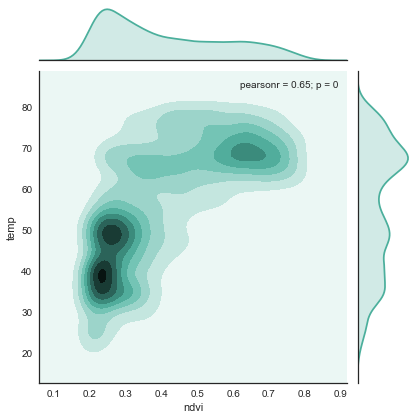

In [257]:
sns.jointplot(x="ndvi", y="temp", data=data_week, kind="kde", color='#4baf9c')
plt.savefig('../img/ndvi-temp.png', transparent=True, dpi=150)

In [153]:
temp_ndvi_yields = data_week[['field', 'temp', 'ndvi', 'yields']].groupby('field').mean()

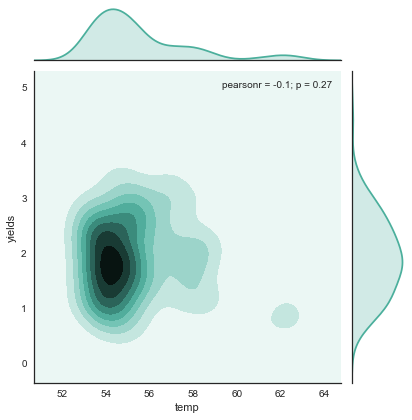

In [179]:
sns.jointplot(x="temp", y="yields", data=temp_ndvi_yields, kind="kde", color='#4baf9c')
plt.savefig('../img/temp-yields.png', dpi=150)

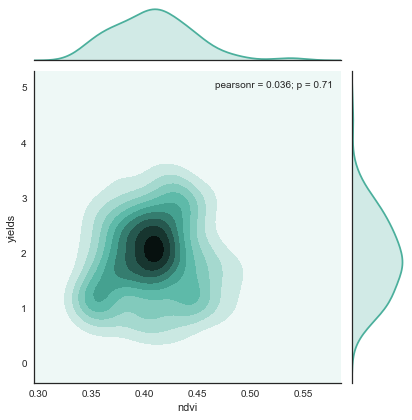

In [181]:
sns.jointplot(x="ndvi", y="yields", data=temp_ndvi_yields, kind="kde", color='#4baf9c')
plt.savefig('../img/ndvi-yields.png', dpi=150)

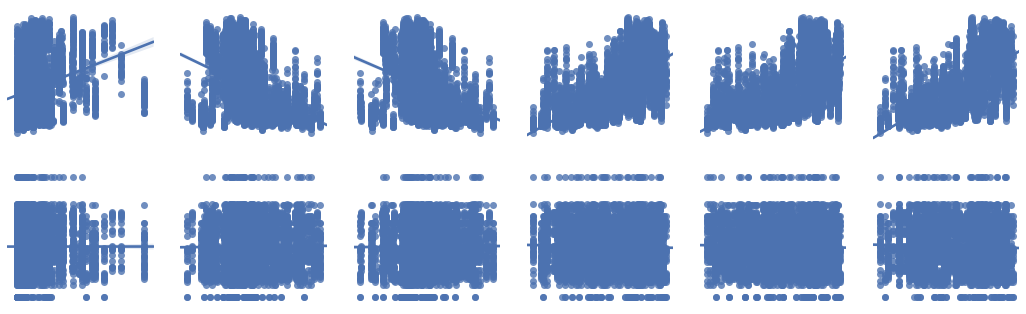

In [214]:
x_vars = ['prcp', 'slp', 'stp', 'temp', 'max', 'min']
y_vars = ['ndvi', 'yields']

f = sns.pairplot(data_week, x_vars=x_vars, y_vars=y_vars, palette=['#4baf9c'], kind='reg', diag_kind='kde', diag_kws=dict(shade=True))
sns.despine(left=True, bottom=True)

for i in range(len(y_vars)):
    for j in range(len(x_vars)):
        f.axes[i, j].get_xaxis().set_visible(False)
        f.axes[i, j].get_yaxis().set_visible(False)

In [184]:
data_week.columns

Index(['index', 'year', 'week', 'temp', 'dewp', 'slp', 'stp', 'visib', 'wdsp',
       'mxspd', 'max', 'min', 'prcp', 'sndp', 'fog', 'rain', 'snow', 'hail',
       'thunder', 'tornado', 'field', 'ndvi', 'yields'],
      dtype='object')

In [258]:
from scipy.stats import spearmanr

In [259]:
spearmanr(data_week['ndvi'], data_week['yields'])

SpearmanrResult(correlation=-0.0046645892996389476, pvalue=0.72567363582700073)

In [260]:
spearmanr(data_week['temp'], data_week['yields'])

SpearmanrResult(correlation=-0.028024024861910281, pvalue=0.034990757206233632)

In [261]:
spearmanr(data_week['ndvi'], data_week['temp'])

SpearmanrResult(correlation=0.67455718553613742, pvalue=0.0)